# Neural Encoding Dataset | Synthetic fMRI Data Tutorial

In this tutorial you will familiarize with the synthetic fMRI responses of the [Neural Encoding Dataset (NED)][ned]. This tutorial is also available on [Colab][colab].

We generated the synthetic fMRI responses using encoding models trained on the [Natural Scenes Dataset (NSD)][nsd] ([Allen et al., 2022][allen]), a large-scale dataset of high-quality 7T fMRI responses from 8 subjects who each viewed 9,000–10,000 distinct color natural scenes. We trained feature-weigthed receptive field encoding models ([St-Yves & Naselaris, 2018][st-yves]) on all 8 NSD subjects over 23 visual ROIs, and used them to synthesize fMRI responses for the:
* 73,000 [NSD][nsd] images;
* 50,000 [ILSVRC-2012 validation][imagenet] images ([Russakovsky et al., 2015][russakovsky]);
* 26,107 [THINGS initiative][things] images ([Hebart et al., 2019][hebart]).

For more information on NED, please refer to the [data manual][data_manual]. The code used to create NED (e.g., encoding models training, evaluation and deployment), along with utility functions (e.g., to use the NED's trained models to generate neural responses for any image of your choice), is available on [GitHub][github].

If you experience problems with the code please get in touch with Ale (alessandro.gifford@gmail.com).

If you use the code and/or data of this tutorial, please cite:

* (Gifford et al., 2024) --> coming soon!

[ned]: https://drive.google.com/drive/folders/1flyZw95cZGBTbePByWUKN6JQz1j1HoYh?usp=drive_link
[colab]: https://colab.research.google.com/drive/1W9Sroz2Y0eTYfyhVrAJwe50GGHHAGBdE?usp=drive_link
[nsd]: https://naturalscenesdataset.org/
[allen]: https://doi.org/10.1038/s41593-021-00962-x
[imagenet]: https://www.image-net.org/challenges/LSVRC/2012/index.php
[russakovsky]: https://doi.org/10.1007/s11263-015-0816-y
[things]: https://things-initiative.org/
[hebart]: https://doi.org/10.1371/journal.pone.0223792
[imagenet]: https://www.image-net.org/challenges/LSVRC/2012/index.php#
[st-yves]: https://doi.org/10.1016/j.neuroimage.2017.06.035
[ned_paper]: !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[data_manual]: https://docs.google.com/document/d/1DeQwjq96pTkPEnqv7V6q9g_NTHCjc6aYr6y3wPlwgDE/edit?usp=drive_link
[github]: https://github.com/gifale95/neural_encoding_dataset

## 0.1 | Install and import the necessary Python libraries

### 0.1.1 | Install libraries, Jupyter Notebook

If you are running the tutorial on Jupyter Notebook, you need to install the following libraries on your local machine before running the tutorial: [numpy][numpy], [h5py][h5py], [nibabel][nibabel], [pillow][pil], [torchvision][torchvision], [matplotlib][matplotlib], [jupyter][jupyter].

[numpy]: https://numpy.org/
[nibabel]: https://nipy.org/nibabel/
[pil]: https://pypi.org/project/pillow/
[h5py]: https://docs.h5py.org/en/stable/
[torchvision]: https://pytorch.org/vision/stable/index.html
[matplotlib]: https://matplotlib.org/stable/index.html
[jupyter]: https://jupyter.org/
[anaconda]: https://www.anaconda.com/
[env_file]: !!!

### 0.1.2 | Import the libraries

Once you have installed all necessary libraries, import them with the following code.

In [2]:
import os
import numpy as np
import h5py
import nibabel as nib
from PIL import Image
import torchvision
from torchvision import transforms as trn
import matplotlib
from matplotlib import pyplot as plt

## 0.2 | Access the data

If you are running the tutorial on Jupyter Notebook you first need to download the data from the public Google Drive folder [`neural_encoding_dataset`][data].

Then edit the `ned_dir` variable below with the path to the downloaded and unzipped data folder.

[data]: https://drive.google.com/drive/folders/1flyZw95cZGBTbePByWUKN6JQz1j1HoYh?usp=drive_link

In [ ]:
ned_dir = '../neural_encoding_dataset'

# 1 | Load and visualize the data

## 1.1 | Data selection

Here you can choose the subject, ROI and imageset of the synthetic fMRI responses.

We provide synthetic fMRI responses for the following (NSD) ROIs:
* **Early retinotopic visual regions:** V1, V2, V3, hV4.
* **Body-selective regions:** EBA, FBA-2.
* **Face-selective regions:** OFA, FFA-1, FFA-2.
* **Place-selective regions:** OPA, PPA, RSC.
* **Word-selective regions:** OWFA, VWFA-1, VWFA-2, mfs-words.
* **Anatomical streams:** early, midventral, midlateral, midparietal, ventral, lateral, parietal.

For more information on the NSD ROIs, please see the [NSD data manual][nsd_man].

[nsd_man]: https://cvnlab.slite.page/p/X_7BBMgghj/ROIs

In [34]:
# Choose subject
sub = 1 # @param ["1", "2", "3", "4", "5", "6", "7", "8"] {type:"raw", allow-input: true}
print('Subject: ' + str(sub))

# Choose ROI
roi = "V1" # @param ["V1", "V2", "V3", "hV4", "EBA", "FBA-2", "OFA", "FFA-1", "FFA-2", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"] {allow-input: true}
print('ROI: ' + roi)

# Choose imageset
imageset = "nsd" # @param ["nsd", "imagenet_val", "things"] {allow-input: true}
print('Imageset: ' + imageset)

Subject: 1
ROI: V1
Imageset: nsd


## 1.2 | Load the synthetic fMRI responses

Now you will load and visualize the synthetic fMRI responses.

The synthetic fMRI responses are stored in the files (`synthetic_neural_responses_training_dataset-nsd_model-fwrf_imageset-*_sub-*_roi-*.h5`), and consist in a 2-D array of shape (N images × N voxels).

The files (`synthetic_neural_responses_metadata_training_dataset-nsd_model-fwrf_imageset-*_sub-*_roi-*.npy`) contain metadata related to the synthetic fMRI responses.

In [35]:
# Load the synthetic fMRI data
data_dir = os.path.join(ned_dir, 'dataset', 'modality-fmri',
    'training_dataset-nsd', 'model-fwrf', 'synthetic_neural_responses',
    'imageset-'+imageset)
file_name = 'synthetic_neural_responses_training_dataset-nsd_' + \
    'model-fwrf_imageset-' + imageset + '_sub-' + format(sub, '02') + \
    '_roi-' + roi + '.h5'
data = h5py.File(os.path.join(data_dir, file_name),
    'r').get('synthetic_neural_responses')

# Load the synthetic fMRI metadata
file_name = 'synthetic_neural_responses_metadata_training_dataset-nsd_' + \
    'model-fwrf_imageset-' + imageset + '_sub-' + format(sub, '02') + \
    '_roi-' + roi + '.npy'
metadata = np.load(os.path.join(data_dir, file_name), allow_pickle=True).item()

# Visualize the synthetic fMRI data dimensions
print('Synthetic fMRI data shape:')
print(data.shape)
print('(Images × Voxels)')

Synthetic fMRI data shape:
(73000, 1350)
(Images × Voxels)


## 1.3 | Link the synthetic fMRI responses to the corresponding images

Here you will match the fMRI responses to the corresponding images. You will start by accessing the imagesets. Since the NSD, ILSVRC-2012, and THINGS imagesets are organized differently, you will access each of them in a different way.

In [36]:
# Access the imagesets
if imageset == 'nsd':
    imageset_dir = os.path.join(ned_dir, 'imagesets', 'imageset-nsd',
        'nsd_stimuli.hdf5')
    images = h5py.File(imageset_dir, 'r')
    images = images.get('imgBrick')
elif imageset == 'imagenet_val':
    imageset_dir = os.path.join(ned_dir, 'imagesets', 'imageset-imagenet_val')
    images = torchvision.datasets.ImageNet(root=imageset_dir, split='val')
elif imageset == 'things':
    images = metadata['things_labels']['image_paths']

Here you can choose an image (indexing is zero-based), and link it to the corresponding synthetic fMRI response.

In [37]:
# Choose the image
if imageset == 'nsd':
    nsd_img = 0 # @param {type:"slider", min:0, max:72999, step:1}
    img_idx = nsd_img
elif imageset == 'imagenet_val':
    imagenet_img = 0 # @param {type:"slider", min:0, max:49999, step:1}
    img_idx = imagenet_img
elif imageset == 'things':
    things_img = 0 # @param {type:"slider", min:0, max:26106, step:1}
    img_idx = things_img

# Link the image to the corresponding synthetic fMRI response
fmri_response = data[img_idx]
print('Synthetic fMRI image response shape:')
print(fmri_response.shape)
print('(Voxels)')

Synthetic fMRI image response shape:
(1350,)
(Voxels)


And now you will load and visualize the image you chose, along with optional metadata (e.g., image category).

Since the ILSVRC-2012 images are rectangular, we center cropped them to square format prior to feeding them to encoding models to synthesize their corresponding fMRI responses. Here you will apply the same center cropping when loading these images. The NSD and THINGS images are already in square format, and therefore don't need any cropping.

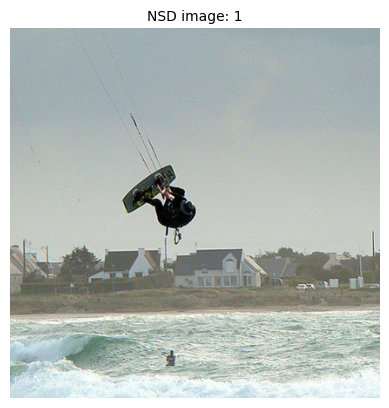

In [38]:
# Load the selected image
if imageset == 'nsd':
    img = images[img_idx]
elif imageset == 'imagenet_val':
    img, _ = images.__getitem__(img_idx)
    transform = trn.Compose([trn.CenterCrop(min(img.size))])
    img = transform(img)
elif imageset == 'things':
    img_dir = os.path.join(ned_dir, 'imagesets', 'imageset-things',
        images[img_idx])
    img = Image.open(img_dir).convert('RGB')

# Visualize the image (along with otptional metadata)
plt.figure()
plt.axis('off')
plt.imshow(img)
if imageset == 'nsd':
    title = 'NSD image: ' + str(img_idx+1)
elif imageset == 'imagenet_val':
    label_number = metadata['imagenet_val_labels']['label_number'][img_idx]
    label_name = metadata['imagenet_val_labels']['label_names'][label_number]
    title = 'ILSVRC-2012 validation image: ' + str(img_idx+1) + \
        '\nCategory number: ' + str(label_number+1) + \
        '\nCategory name: ' + label_name
elif imageset == 'things':
    object_concept_number = \
        metadata['things_labels']['image_concept_index'][img_idx]
    object_concept_name = \
        metadata['things_labels']['unique_id'][object_concept_number]
    file_name = \
        metadata['things_labels']['image_paths'][img_idx]
    title = 'THINGS image: ' + str(img_idx+1) + \
        '\nObject concept number: ' + str(object_concept_number+1) + \
        '\nObject concept name: ' + object_concept_name + \
        '\nFile name: ' + file_name
plt.title(title, fontsize=10);

## 1.4 | Reshape the synthetic fMRI responses to subject-native volume space

The synthetic fMRI responses metadata contain the `roi_mask_volume` and `fmri_affine` variables, which you can use to map the voxel responses of the selected subject and ROI back to 3-D subject-native volume space, and from there to a nifti image. `roi_mask_volume` is a 3-D boolean matrix covering the entire fMRI acquisition volume space, with ones indicate voxels pertaining to the selected subject and ROI. `fmri_affine` is the 4×4 affine tranformation matrix.

In [39]:
# Reshape the synthetic fMRI response for the chosen image back to
# subject-native volume space
sub_native_vol_space = np.zeros(metadata['fmri']['roi_mask_volume'].shape)
sub_native_vol_space[metadata['fmri']['roi_mask_volume']] = data[img_idx]
print('Subject-native volume space shape:')
print(sub_native_vol_space.shape)
print('(Voxels × Voxels × Voxels)')

# Convert the data into a nifti image
sub_native_vol_space_nii = nib.Nifti1Image(sub_native_vol_space,
    metadata['fmri']['fmri_affine'])

# You can then save the new nifti image using the following function:
# >>> nib.save(sub_native_vol_space_nii, 'sub_native_vol_space_nii.nii')

Subject-native volume space shape:
(81, 104, 83)
(Voxels × Voxels × Voxels)


## 1.5 | Plot the encoding models prediction accuracy

For each NSD subject, we trained the encoding models using the (up to) 9000 non-shared images (i.e., the images uniquely seen by each subject), and tested them on 515 (out of 1000) shared images (i.e., the 515 images that each subject saw for exactly three times). We used the trained encoding models to synthesize the fMRI responses for the 515 test images, and compared these synthetic responses to the ground truth (real) fMRI responses through a Pearson correlation. We correlated ground-truth and synthetic fMRI responses independently for each voxel (across the 515 test images), resulting in a prediction accuracy score for each voxel. Finally, we normalized the *r*² correlation scores through division with the noise ceiling (i.e., the maximal explainable variance given the noise in the data), obtaining the noise-ceiling-normalized encoding accuracy for each voxel: this score indicates the percentage of explainable variance that has been accounted for by the encoding model.

You will first plot the mean noise-ceiling-normalized encoding accuracy across all voxels of the chosen ROI.

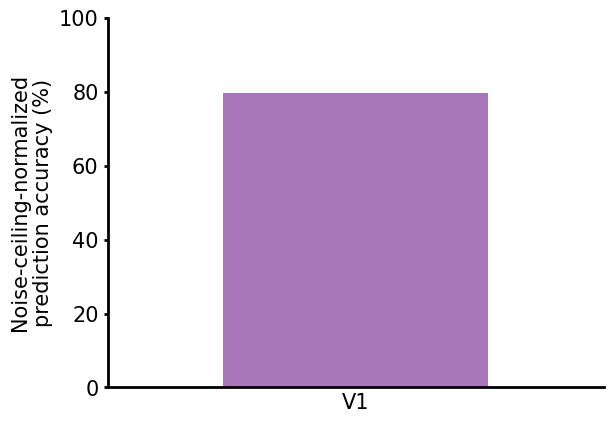

In [40]:
# Plot parameters
fontsize = 15
matplotlib.rcParams['font.sans-serif'] = 'DejaVu Sans'
matplotlib.rcParams['font.size'] = fontsize
plt.rc('xtick', labelsize=fontsize)
plt.rc('ytick', labelsize=fontsize)
matplotlib.rcParams['axes.linewidth'] = 2
matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['xtick.major.size'] = 3
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['ytick.major.size'] = 3
matplotlib.rcParams['axes.spines.left'] = True
matplotlib.rcParams['axes.spines.bottom'] = True
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['lines.markersize'] = 3
colors = [(170/255, 118/255, 186/255)]

# Plot the mean noise-ceiling normalized encoding accuracy
encoding_acc = np.mean(metadata['encoding_models']['encoding_accuracy']\
    ['noise_normalized_encoding']) * 100
plt.plot()
plt.bar(1, encoding_acc, color=colors[0])
plt.ylabel('Noise-ceiling-normalized\nprediction accuracy (%)',
    fontsize=fontsize)
plt.ylim(bottom=0, top=100)
plt.xlabel(roi, fontsize=fontsize)
plt.xticks([])
plt.xlim(left=0.25, right=1.75);

Finally, you will plot the voxel-wise prediction accuracy scores (*r²* scores) against the corresponding noise ceiling scores, on a scatterplot.

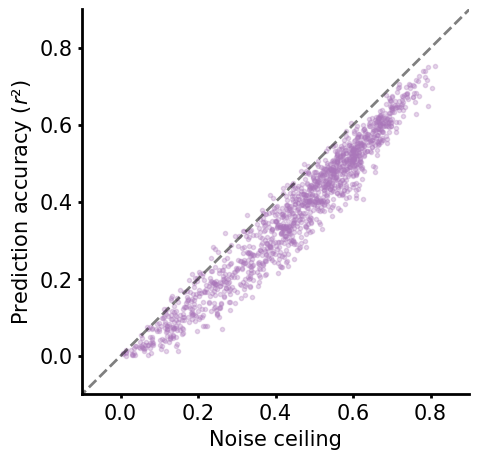

In [41]:
r2 = metadata['encoding_models']['encoding_accuracy']['r2']
noise_ceiling = metadata['encoding_models']['encoding_accuracy']['noise_ceiling']

plt.figure(figsize=(5,5))
plt.plot(np.arange(-1,1.1,.1), np.arange(-1,1.1,.1), '--k', linewidth=2,
    alpha=.5)
plt.scatter(noise_ceiling, r2, color=colors[0], alpha=.3)
plt.ylabel('Prediction accuracy ($r$²)', fontsize=fontsize)
plt.ylim(bottom=-.1, top=.9)
plt.xlabel('Noise ceiling', fontsize=fontsize)
plt.xlim(left=-.1, right=.9);